# Importing

In [1]:
# Required Libraries installation
!pip install pyspark
!pip install pandas scikit-learn nltk pygal pandas-profiling[notebook]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [99]:
# Importing Libraries
from google.colab import drive
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from builtins import min,max
#--------------------------------------------------------------
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, when,round,month,datediff, to_date
from pyspark.sql.window import Window
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, StructType, StructField
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import split
from pyspark.sql.functions import regexp_replace, col
from pyspark.sql.functions import collect_set, size, explode
from pyspark.sql.functions import udf
from pyspark.sql.functions import min as min_builtin
from pyspark.sql.functions import max as max_builtin
from pyspark.sql.functions import countDistinct, mean
from pyspark.sql.functions import quarter
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.fpm import FPGrowth
from pyspark.ml.clustering import BisectingKMeans
#--------------------------------------------------------------
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
#--------------------------------------------------------------
import pygal
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
import plotly.express as px
from operator import add

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Helper function

In [4]:
# helper functions
def show_df(df, n=5):
  return df.show(n)

def df_stats(df):
  return df.describe().show()



def percent_missing(df):
  cols = [col for col in df.columns if col != 'InvoiceDate']
  # count missing values in each column as a percentage of the total number of values and total number of values in each column
  df.select([count(when(~isnan(c), c)).alias(c) for c in cols]).show()
  df.select([count(when(isnan(c), c)).alias(c) for c in cols]).show()


def values_distribution(df,col,bins=100,xlim=10000,xlabel='TotalCost',ylabel='Frequency',title='Distribution of basket prices'):
  df_pd = df.toPandas()
  fig, ax = plt.subplots()
  ax.hist(df_pd[col], bins=bins)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  plt.rc('xtick', labelsize=10)
  plt.rc('ytick', labelsize=10)
  ax = plt.gca()
  ax.set_xlim([0,xlim])
  plt.show()

# Reading DataSet

In [5]:
# Create a SparkSession
spark = SparkSession.builder.master("local[4]").appName("ClusterShop").getOrCreate()

# set log level to Error
spark.sparkContext.setLogLevel("ERROR")


In [6]:
# Read the Excel file using Pandas
df_pandas = pd.read_excel("drive/MyDrive/Online Retail.xlsx",na_values='')

# Convert the Pandas DataFrame to PySpark DataFrame 
df_spark = spark.createDataFrame(df_pandas)

# Data cleaning

In [7]:
percent_missing(df_spark)

+---------+---------+-----------+--------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+---------+----------+-------+
|   541909|   541909|     540455|  541909|   541909|    406829| 541909|
+---------+---------+-----------+--------+---------+----------+-------+

+---------+---------+-----------+--------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+---------+----------+-------+
|        0|        0|       1454|       0|        0|    135080|      0|
+---------+---------+-----------+--------+---------+----------+-------+



In [8]:
# filter out the missing values using map 
df_spark_filtered = df_spark.rdd.map(lambda x: x if not math.isnan(x['CustomerID'])  else None).filter(lambda x: x is not None).toDF()

In [9]:
number_befoe_removing_duplicates = df_spark_filtered.count()
#I want to remove duplicates while perserving the original order of the rows
df_spark_filtered = df_spark_filtered.dropDuplicates()
df_spark_filtered= df_spark_filtered.orderBy('InvoiceNo', 'InvoiceDate')
number_after_removing_duplicates = df_spark_filtered.count()
print(f"Number of duplicates: {number_befoe_removing_duplicates - number_after_removing_duplicates}")

Number of duplicates: 5225


In [10]:
original_cols = df_spark.columns

# EDA

## overall analysis

In [11]:
spark

In [12]:
df_spark.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



In [13]:
df_spark.show(5)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 5 rows



## InvoiceNo
* uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* 6-digit integral number

### percentage of cancelled

In [14]:
unique_invoice = df_spark_filtered.select('InvoiceNo').distinct().count()
cancelled_invoice_count = df_spark_filtered.select('InvoiceNo').rdd.map(lambda x: x if x.InvoiceNo.startswith('C') else None).filter(lambda x: x is not None).toDF()

cancelled_invoice_count = cancelled_invoice_count.select('InvoiceNo').distinct().count()


# percentage of cancelled invoices
print("Percentage of cancelled invoices: ", (cancelled_invoice_count/unique_invoice)*100)

Percentage of cancelled invoices:  16.466876971608833


In [15]:
df_sorted_CustomerID = df_spark_filtered.sort('CustomerID')
df_sorted_CustomerID.show(5)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   541431|    23166|MEDIUM CERAMIC TO...|   74215|2011-01-18 10:01:00|     1.04|   12346.0|United Kingdom|
|  C541433|    23166|MEDIUM CERAMIC TO...|  -74215|2011-01-18 10:17:00|     1.04|   12346.0|United Kingdom|
|   537626|    21731|RED TOADSTOOL LED...|      12|2010-12-07 14:57:00|     1.65|   12347.0|       Iceland|
|   537626|    84969|BOX OF 6 ASSORTED...|       6|2010-12-07 14:57:00|     4.25|   12347.0|       Iceland|
|   542237|    22375|AIRLINE BAG VINTA...|       4|2011-01-26 14:30:00|     4.25|   12347.0|       Iceland|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 5 rows



* Look at the first two transactions are the same(StockCode,Description,UnitPrice,CustomerID,Country)
* and different(InvoiceNo,sign of Quantity,InvoiceDate)
* which means the second transaction is a cancellation of the first one

### check if every neg transaction has a pos pair

* try to check if every negative quantity transaction (cancellation) has a positive quantity transaction in our data

In [16]:
df_check = df_spark_filtered.filter(col('Quantity') < 0).select('CustomerID', 'Quantity', 'StockCode', 'Description', 'UnitPrice')
for row in df_check.rdd.collect():
    if df_spark_filtered.filter((col('CustomerID') == row[0]) & (col('Quantity') == -row[1]) & (col('Description') == row[2])).count() == 0:
        print(row)
        print(15*'-'+'>'+' not every negative quantity transaction (cancellation) has a positive quantity transaction in our data')
        break

Row(CustomerID=14527.0, Quantity=-1, StockCode='D', Description='Discount', UnitPrice=27.5)
---------------> not every negative quantity transaction (cancellation) has a positive quantity transaction in our data


* we will discard the Discount transactions

In [17]:
df_check = df_spark_filtered.filter((col('Quantity') < 0) & (col('Description')!='Discount')).select('CustomerID', 'Quantity', 'StockCode', 'Description', 'UnitPrice')
for row in df_check.rdd.collect():
    if df_spark_filtered.filter((col('CustomerID') == row[0]) & (col('Quantity') == -row[1]) & (col('Description') == row[2])).count() == 0:
        print(row)
        print(15*'-'+'>'+' not every negative quantity transaction (cancellation) has a positive quantity transaction in our data')
        break

Row(CustomerID=15311.0, Quantity=-1, StockCode='35004C', Description='SET OF 3 COLOURED  FLYING DUCKS', UnitPrice=4.65)
---------------> not every negative quantity transaction (cancellation) has a positive quantity transaction in our data


* Then not every negative quantity transaction (cancellation) has a positive quantity transaction in our data
* May be its positive pair was before the starting date of our data or removed by the data cleaning process (having null CustomerID)

## StockCode
* uniquely assigned to each distinct product
* 5-digit integral number

### Number of unique products

In [18]:
number_of_unique_products = df_spark_filtered.select('StockCode').distinct().count()
print(f"Number of unique products: {number_of_unique_products}")

Number of unique products: 3684


### stockCodes that are not numbers

In [19]:
#get stockCodes that are not numbers
from pyspark.sql.functions import regexp_extract, col
list_special_codes = df_spark_filtered.select(['StockCode','Description']).filter(col('StockCode').rlike('^[a-zA-Z]+'))
list_special_codes.distinct().show()

+------------+--------------------+
|   StockCode|         Description|
+------------+--------------------+
|        POST|             POSTAGE|
|         DOT|      DOTCOM POSTAGE|
|           D|            Discount|
|          C2|            CARRIAGE|
|BANK CHARGES|        Bank Charges|
|        PADS|PADS TO MATCH ALL...|
|           M|              Manual|
|        CRUK|     CRUK Commission|
+------------+--------------------+



### most popular items

In [20]:
#most popular items ==for every StockCode count the sum of the Quantity in all the invoices and return the top 5
from pyspark.sql.functions import sum
df_spark_filtered.groupBy('StockCode').agg(sum('Quantity').alias('Quantity')).orderBy('Quantity', ascending=False).show(5)

+---------+--------+
|StockCode|Quantity|
+---------+--------+
|    84077|   53119|
|    22197|   48689|
|   85099B|   44963|
|    84879|   35215|
|   85123A|   34185|
+---------+--------+
only showing top 5 rows



## Description
Product (item) name. Nominal.

### Number of keywords

In [21]:
def is_noun(pos):
    '''
    In the Penn Treebank system, the POS tag for a noun is 'NN'.
    https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
    '''
    return pos[:2] == 'NN'

In [22]:
def extract_nouns(sentence):
    '''
    extract nouns from a sentence 
    using nltk's part-of-speech tagging
    '''
    if sentence is None:
        return []
    else:
        stemmer = nltk.stem.SnowballStemmer("english")
        tokenized = nltk.word_tokenize(sentence.lower())
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
        return [stemmer.stem(noun) for noun in nouns]


In [23]:
# https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.sql.functions.udf.html
extract_nouns_udf = udf(extract_nouns, ArrayType(StringType()))

keywords_schema = StructType([
    StructField("category_key", StringType(), True),
    StructField("keywords_roots", StringType(), True),
    StructField("keywords_select", StringType(), True),
    StructField("count_keywords", StringType(), True)
])

In [24]:
stemmer = nltk.stem.SnowballStemmer("english")
keywords_roots = dict()  # collect the words / root
keywords_select = dict()  # association: root <-> keyword
category_keys = []  # stores the representative keyword for each group of related words.
count_keywords = dict()

In [25]:
def keywords_inventory(dataframe, colonne='Description'):
    '''
     1.applies the extract_nouns_udf 
     2.uses the nltk library to stem the extracted nouns and collect them into a dictionary of keywords and their corresponding roots.
     3.selects a representative keyword for each group of roots based on the length of the keyword.
    '''

    #1.
    dataframe = dataframe.withColumn("nouns", extract_nouns_udf(dataframe[colonne]))

    #2.
    for row in dataframe.select("nouns").collect():
        nouns = row[0]
        for t in nouns:
            racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    #3.
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
    
    result = [[category_keys[i], list(keywords_roots.keys())[i], keywords_select[list(keywords_roots.keys())[i]], count_keywords[list(keywords_roots.keys())[i]]] for i in range(len(category_keys))]
    return spark.createDataFrame(result, schema=keywords_schema)

In [26]:
df_products_desc = df_spark_filtered.select('Description').distinct()
# Apply the keywords_inventory function to the dataframe
keywords = keywords_inventory(df_products_desc)
# Display the number of keywords
print("Number of keywords: ", keywords.count())

Number of keywords:  1482


### words freq

+------------+--------------+---------------+--------------+
|category_key|keywords_roots|keywords_select|count_keywords|
+------------+--------------+---------------+--------------+
|       heart|         heart|          heart|           267|
|      vintag|        vintag|         vintag|           211|
|         set|           set|            set|           206|
|        pink|          pink|           pink|           189|
|         bag|           bag|            bag|           165|
|         box|           box|            box|           155|
|       glass|         glass|          glass|           149|
|    christma|      christma|       christma|           137|
|      design|        design|         design|           128|
|       candl|         candl|          candl|           121|
|      holder|        holder|         holder|           120|
|      flower|        flower|         flower|           120|
|       decor|         decor|          decor|           109|
|       metal|         m

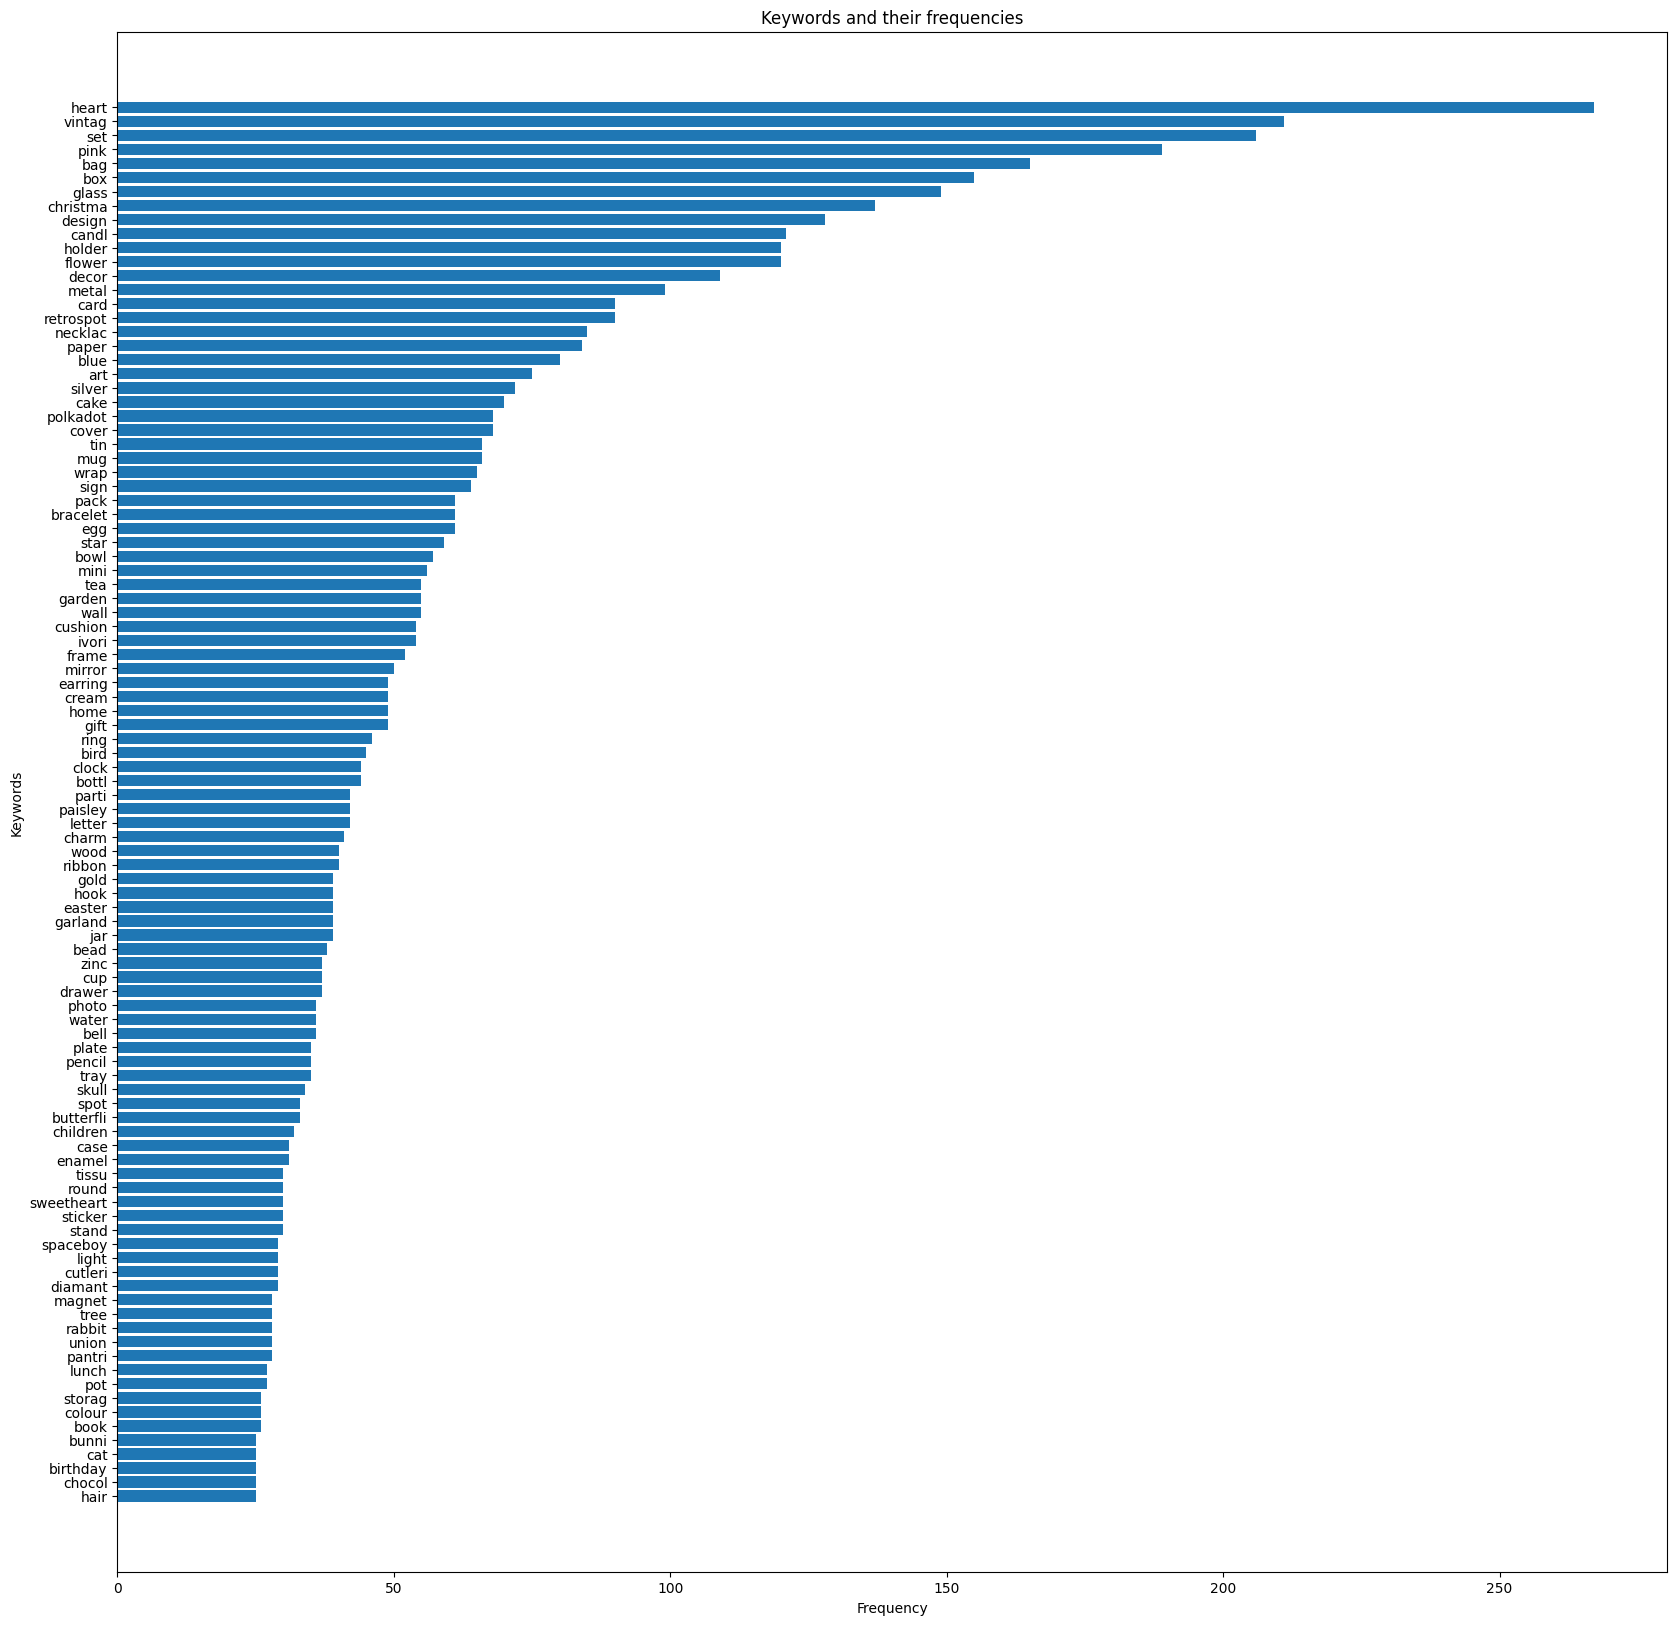

In [27]:
# sort the keywords by their frequencies after converting the count_keywords column to integer  
keywords = keywords.withColumn("count_keywords", keywords["count_keywords"].cast("int")).sort("count_keywords", ascending=False)
keywords.show()

keywords_pd = keywords.toPandas()

# plot the horizontal bar chart
fig, ax = plt.subplots(figsize=(20, 20))
ax.barh(keywords_pd['category_key'][:100], keywords_pd['count_keywords'][:100])
ax.set_xlabel('Frequency')
ax.set_ylabel('Keywords')
ax.set_title('Keywords and their frequencies')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
ax = plt.gca()
ax.invert_yaxis()
plt.show()

In [28]:
# consider only the keywords with frequency greater than 15
keywords_filtered = keywords.filter(keywords['count_keywords'] > 15)
print("Number of keywords: ", keywords_filtered.count())

Number of keywords:  162


### Get most frequent items based on description

In [29]:
count_keywords = keywords_pd['count_keywords'].values.tolist()
keywords_select = keywords_pd['category_key'].values.tolist()

count_keywords = dict(enumerate(count_keywords))
keywords_select = dict(enumerate(keywords_select))

list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 15: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print("Number of products: ", len(list_products))

Number of products:  168


## Quantity
The quantities of each product (item) per transaction. Numeric.


In [30]:
df_spark_filtered.select('Quantity').describe().show()

+-------+------------------+
|summary|          Quantity|
+-------+------------------+
|  count|            401604|
|   mean|12.183272576966365|
| stddev|250.28303714445414|
|    min|            -80995|
|    max|             80995|
+-------+------------------+



## CustomerID
*  a 5-digit integral number uniquely assigned to each customer

### get number of unique customers

In [31]:
#get number of unique customers
df_spark_filtered.select('CustomerID').distinct().count()

4372

In [32]:
# group by CustomerID, InvoiceNo, and count the number of rows
from pyspark.sql.functions import count
temp = df_spark_filtered.groupBy('CustomerID', 'InvoiceNo').agg(count('Quantity').alias('Number of products')).orderBy('CustomerID', ascending=True)
temp.show(10)

+----------+---------+------------------+
|CustomerID|InvoiceNo|Number of products|
+----------+---------+------------------+
|   12346.0|   541431|                 1|
|   12346.0|  C541433|                 1|
|   12347.0|   562032|                22|
|   12347.0|   556201|                18|
|   12347.0|   542237|                29|
|   12347.0|   581180|                11|
|   12347.0|   537626|                31|
|   12347.0|   573511|                47|
|   12347.0|   549222|                24|
|   12348.0|   548955|                 5|
+----------+---------+------------------+
only showing top 10 rows



* Invoices starts whit C are cancelled
* there are customers only buy small quantities of products and other customers buy large quantities of products

## InvoiceDate

### Range of dates

In [33]:
#min and max date
print(f"the minimum date is: {df_spark_filtered.select('InvoiceDate').agg({'InvoiceDate': 'min'}).collect()[0][0]}")
print(f"the maximum date is: {df_spark_filtered.select('InvoiceDate').agg({'InvoiceDate': 'max'}).collect()[0][0]}")

the minimum date is: 2010-12-01 08:26:00
the maximum date is: 2011-12-09 12:50:00


## Country

### Number of countries

In [34]:
number_countries=df_spark_filtered.select('Country').distinct().count()
print(f"Number of countries: {number_countries}")

Number of countries: 37


### countries that made most of transactions

Sum of invoice counts: 22190


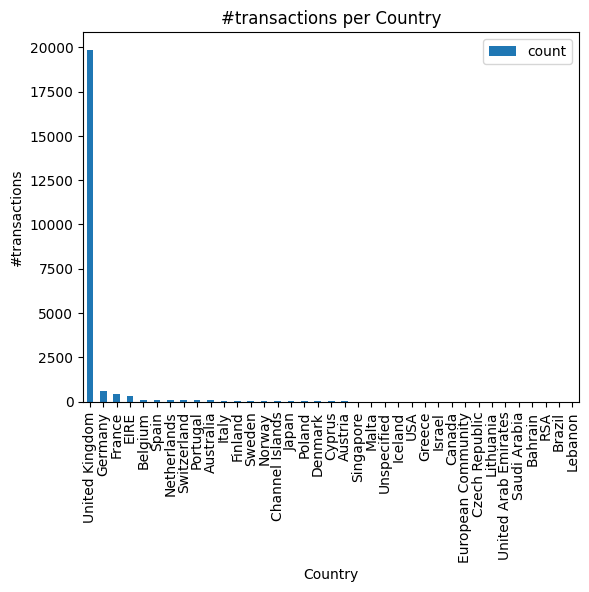

In [35]:
invoice_counts = df_spark_filtered.groupBy(['Country', 'InvoiceNo']).count().groupBy('Country').count().orderBy('count', ascending=False)
#print sum of invoice_counts
print(f"Sum of invoice counts: {invoice_counts.agg({'count': 'sum'}).collect()[0][0]}")
pandas_df = invoice_counts.toPandas()
pandas_df.plot(kind="bar", x="Country", y="count")
plt.title("#transactions per Country")
plt.xlabel("Country")
plt.ylabel("#transactions")
plt.show()

### countries that made most of cancellations

Sum of cancelled invoice counts: 3654


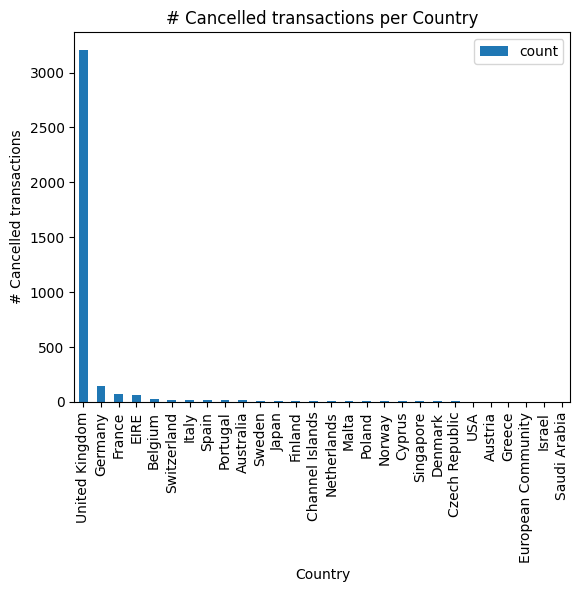

In [36]:
cancelled_invoice_counts = df_spark_filtered.filter(df_spark_filtered['InvoiceNo'].contains('C')).groupBy(['Country', 'InvoiceNo']).count().groupBy('Country').count().orderBy('count', ascending=False)
print(f"Sum of cancelled invoice counts: {cancelled_invoice_counts.agg({'count': 'sum'}).collect()[0][0]}")
pandas_df = cancelled_invoice_counts.toPandas()
pandas_df.plot(kind="bar", x="Country", y="count")
plt.title("# Cancelled transactions per Country")
plt.xlabel("Country")
plt.ylabel("# Cancelled transactions")
plt.show()

### countries vs num transactions map

In [37]:
df_initial=df_spark_filtered.toPandas()
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning:

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead



In [38]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

# Association Rules

In [39]:
new_col_name = "CleanStockCode"
pattern = "[^0-9]+"
df_spark_cleaned_for_assoc = df_spark_filtered.withColumn(new_col_name, regexp_replace(col("StockCode"), pattern, "").cast("integer"))
df_spark_cleaned_for_assoc.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|CleanStockCode|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+--------------+
|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-12-01 08:26:00|     7.65|   17850.0|United Kingdom|         22752|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|         71053|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|         84406|
|   536365|    21730|GLASS STAR FROSTE...|       6|2010-12-01 08:26:00|     4.25|   17850.0|United Kingdom|         21730|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|         84029|
|   536365|   85

In [40]:
# Define the columns containing the transaction ID and item ID
transaction_col = "CustomerID"
item_col = "CleanStockCode"

# Convert the item_col column to an array of strings
df_spark_filtered_assoc = df_spark_cleaned_for_assoc.withColumn(item_col, split(df_spark_cleaned_for_assoc[item_col], " "))

# Define the minimum support and confidence thresholds
min_support = 0.001
min_confidence = 0.01

# Define the FPGrowth model and fit it to the data
fp_model = FPGrowth(itemsCol=item_col, minSupport=min_support, minConfidence=min_confidence)
fpm = fp_model.fit(df_spark_filtered_assoc)



In [41]:
fpm.freqItemsets.sort('items').show(5)

+-------+----+
|  items|freq|
+-------+----+
|[15056]| 821|
|[16161]| 407|
|[20685]| 584|
|[20712]| 506|
|[20713]| 422|
+-------+----+
only showing top 5 rows



In [42]:
# Define the columns containing the transaction ID and item ID
transaction_col = "InvoiceNo"
item_col = "CleanStockCode"

# Group the data by transaction ID and collect the item IDs into a set
df_grouped = df_spark_cleaned_for_assoc.groupby(transaction_col).agg(collect_set(item_col).alias("items"))

# Define the minimum support and confidence thresholds
min_support = 0.0080
min_confidence = 0.5

# Define the FPGrowth model and fit it to the data
fp_model = FPGrowth(itemsCol="items", minSupport=min_support, minConfidence=min_confidence)
fp_association_rules = fp_model.fit(df_grouped)

# Generate frequent itemsets
freq_itemsets = fp_association_rules.freqItemsets

# Explode the items column into separate rows
df_exploded = freq_itemsets.select(explode("items").alias("items"))


In [43]:
assoc_rules = fp_association_rules.associationRules

eval_metrics = assoc_rules.selectExpr("antecedent", "consequent", "support", "confidence", "lift")
eval_metrics.toPandas()

,antecedent,consequent,support,confidence,lift
0,[82483],[82486],0.012708,0.513661,19.651969
1,"[23199, 85099]",[23203],0.010275,0.512360,10.363955
2,[22748],[22746],0.009734,0.618911,54.069445
3,[22748],[22745],0.011492,0.730659,50.825466
4,[22835],[22112],0.013069,0.568627,17.847020
...,...,...,...,...,...
393,"[23202, 23209]",[23203],0.009283,0.830645,16.802202
394,[22662],[20725],0.013925,0.510744,8.521357
395,[22662],[22382],0.016043,0.588430,13.044212
396,"[20728, 20727, 20725]",[22384],0.008698,0.733840,17.122940


In [44]:
# Convert the evaluation metrics to a Pandas DataFrame
eval_metrics_pd = eval_metrics.toPandas()

# Create a scatter plot of association rules with rule labels and support values
fig = px.scatter(eval_metrics_pd, x="lift", y="confidence", hover_name="antecedent", size_max=10, color="support")

# Update the axis titles and font size
fig.update_layout(
    xaxis_title="lift",
    yaxis_title="Confidence",
    font=dict(size=12)
)

# Show the plot
fig.show()

# Feature Engineering

* Recency - How recently did this customer make his/her last
purchase?
* Frequency - How often did this customer make purchases?
* Monetary value - How much did this customer spend?

## basket price

In [45]:
# Define a function to compute the total cost for each basket
def calculate_basket_total(row):
    customer_id, invoice_no, quantity, unit_price = row
    total_cost = quantity * unit_price
    return ((customer_id, invoice_no), total_cost)
rdd = df_spark_filtered.rdd.map(lambda row: calculate_basket_total((row['CustomerID'], row['InvoiceNo'], row['Quantity'], row['UnitPrice'])))
basket_rdd = rdd.reduceByKey(lambda a, b: a + b)
basket_price = basket_rdd.map(lambda row: (row[0][0], row[0][1], row[1])).toDF(['CustomerID', 'InvoiceNo', 'TotalCost'])
basket_price = basket_price.sort('CustomerID')
show_df( basket_price)

+----------+---------+------------------+
|CustomerID|InvoiceNo|         TotalCost|
+----------+---------+------------------+
|   12346.0|  C541433|          -77183.6|
|   12346.0|   541431|           77183.6|
|   12347.0|   562032|            584.91|
|   12347.0|   542237|475.39000000000004|
|   12347.0|   549222|            636.25|
+----------+---------+------------------+
only showing top 5 rows



In [46]:
# stats of total cost in basket price
df_stats(basket_price.select('TotalCost'))

+-------+------------------+
|summary|         TotalCost|
+-------+------------------+
|  count|             22190|
|   mean| 373.0743318611986|
| stddev|2017.7640578059631|
|    min|         -168469.6|
|    max|          168469.6|
+-------+------------------+



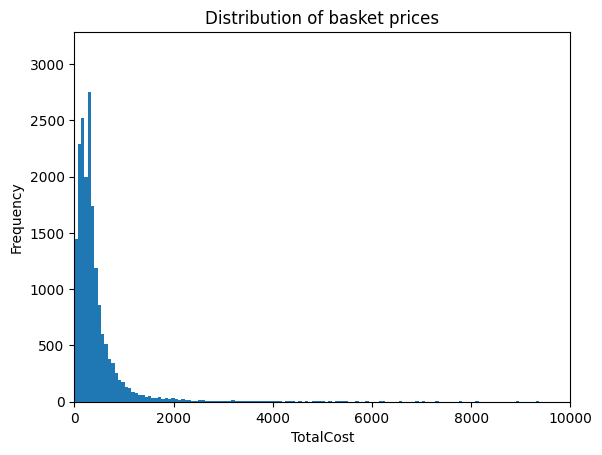

In [47]:
values_distribution(basket_price,'TotalCost',bins=5000,xlim=10000,xlabel='TotalCost',ylabel='Frequency',title='Distribution of basket prices')

## Avg Purchase Value

In [48]:
def calculate_customer_stats(row):
    customer_id, total_cost = row
    return (customer_id, (total_cost, 1))

rdd = basket_price.rdd.map(lambda row: (row['CustomerID'], row['TotalCost'])).map(calculate_customer_stats)

customer_rdd = rdd.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

avg_purchase_value_rdd = customer_rdd.map(lambda row: (row[0], row[1][0] / row[1][1]))

avg_purchase_value = avg_purchase_value_rdd.toDF(['CustomerID', 'AvgPurchaseValue'])

show_df(avg_purchase_value)

+----------+------------------+
|CustomerID|  AvgPurchaseValue|
+----------+------------------+
|   12346.0|               0.0|
|   12347.0| 615.7142857142857|
|   12348.0|            449.31|
|   12349.0|1757.5500000000006|
|   12350.0|             334.4|
+----------+------------------+
only showing top 5 rows



In [49]:
df_stats(avg_purchase_value.select('AvgPurchaseValue'))

+-------+------------------+
|summary|  AvgPurchaseValue|
+-------+------------------+
|  count|              4372|
|   mean| 314.4926926292022|
| stddev|360.85543304917604|
|    min|          -4287.63|
|    max|           6207.67|
+-------+------------------+



In [50]:
avg_purchase_value.filter(avg_purchase_value['AvgPurchaseValue'] < 0).count()
customers_with_neg_avg_purchase_value = avg_purchase_value.filter(avg_purchase_value['AvgPurchaseValue'] < 0).select('CustomerID','AvgPurchaseValue').collect()

print("transactions before removing customers with negative avg purchase value: ", df_spark_filtered.count())
df_spark_filtered = df_spark_filtered.filter(~df_spark_filtered['CustomerID'].isin([x['CustomerID'] for x in customers_with_neg_avg_purchase_value]))
print("transactions after removing customers with negative avg purchase value: ", df_spark_filtered.count())


transactions before removing customers with negative avg purchase value:  401604
transactions after removing customers with negative avg purchase value:  401376


In [51]:
avg_purchase_value = avg_purchase_value.filter(~avg_purchase_value['CustomerID'].isin([x['CustomerID'] for x in customers_with_neg_avg_purchase_value]))
basket_price = basket_price.filter(~basket_price['CustomerID'].isin([x['CustomerID'] for x in customers_with_neg_avg_purchase_value]))

In [52]:
df_stats(avg_purchase_value.select('AvgPurchaseValue'))

+-------+------------------+
|summary|  AvgPurchaseValue|
+-------+------------------+
|  count|              4330|
|   mean| 320.1514824114407|
| stddev|350.99029037640355|
|    min|               0.0|
|    max|           6207.67|
+-------+------------------+



In [53]:
# stats of total cost in basket price
df_stats(basket_price.select('TotalCost'))

+-------+------------------+
|summary|         TotalCost|
+-------+------------------+
|  count|             22125|
|   mean|374.76829667796596|
| stddev|2020.1886771074198|
|    min|         -168469.6|
|    max|          168469.6|
+-------+------------------+



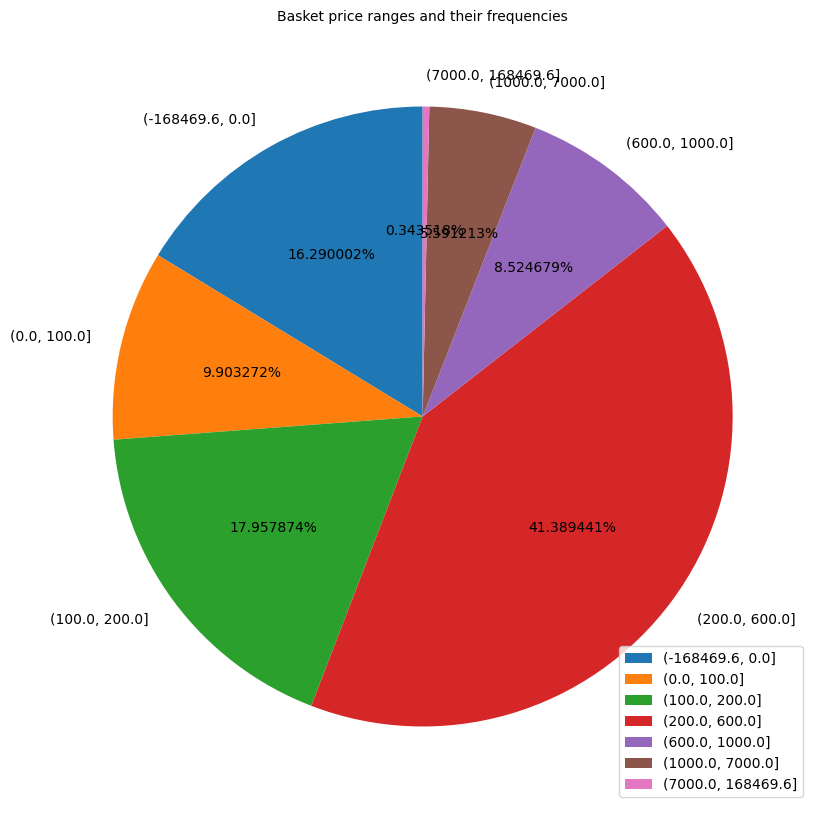

In [54]:
# construct ranges for the basket prices and count the number of baskets in each range
ranges = [-168469.6,0, 100, 200, 600, 1000, 7000,168469.6]
basket_price_pd = basket_price.toPandas()
basket_price_range = basket_price_pd.groupby(pd.cut(basket_price_pd['TotalCost'], ranges)).count()
basket_price_range

ax, fig = plt.subplots(figsize=(10,15))
plt.pie(basket_price_range['TotalCost'], labels=basket_price_range.index, autopct='%1f%%', startangle=90)
plt.title('Basket price ranges and their frequencies', fontsize=10)
plt.legend(basket_price_range.index, loc='lower right', fontsize=10)
plt.show()


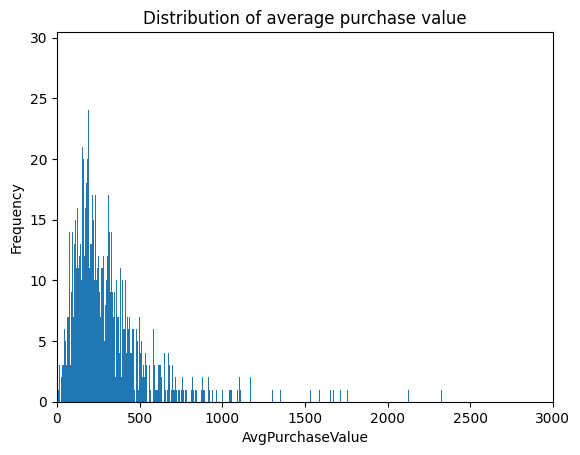

In [55]:
values_distribution(avg_purchase_value,col='AvgPurchaseValue',bins=5000,xlim=3000,xlabel='AvgPurchaseValue',title='Distribution of average purchase value')

## Frequency Of Purchases

In [56]:
rdd = basket_price.rdd.map(lambda row: (row['CustomerID'], 1))

customer_rdd = rdd.reduceByKey(lambda a, b: a + b)

frequency_of_purchases = customer_rdd.toDF(['CustomerID', 'FrequencyOfPurchases'])

show_df(frequency_of_purchases)

+----------+--------------------+
|CustomerID|FrequencyOfPurchases|
+----------+--------------------+
|   12346.0|                   2|
|   12347.0|                   7|
|   12348.0|                   4|
|   12349.0|                   1|
|   12350.0|                   1|
+----------+--------------------+
only showing top 5 rows



In [57]:
df_stats(frequency_of_purchases.select('FrequencyOfPurchases'))

+-------+--------------------+
|summary|FrequencyOfPurchases|
+-------+--------------------+
|  count|                4330|
|   mean|   5.109699769053118|
| stddev|   9.376827828095207|
|    min|                   1|
|    max|                 248|
+-------+--------------------+



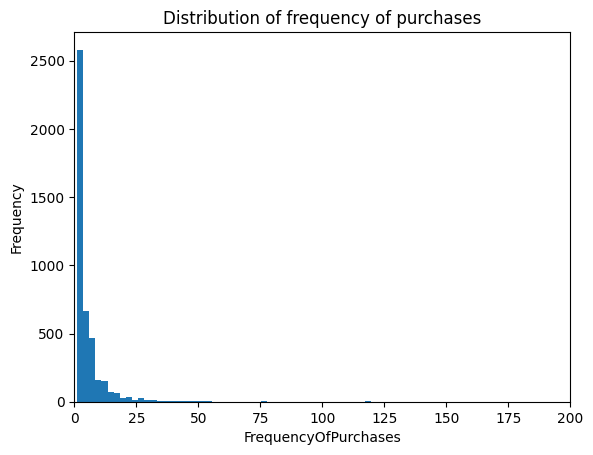

In [58]:
values_distribution(frequency_of_purchases,col='FrequencyOfPurchases',bins=100,xlim=200,xlabel='FrequencyOfPurchases',title='Distribution of frequency of purchases')

## Customer Life time Value

In [59]:
df_spark_filtered = df_spark_filtered.withColumn('InvoiceDate', to_date(df_spark_filtered['InvoiceDate']))

window = Window.partitionBy('CustomerID').orderBy('InvoiceDate')
df_spark_filtered = df_spark_filtered.withColumn('FirstPurchase', min_builtin('InvoiceDate').over(window))
df_spark_filtered = df_spark_filtered.withColumn('LastPurchase', max_builtin('InvoiceDate').over(window))

rdd = df_spark_filtered.rdd.map(lambda row: (row['CustomerID'], (row['InvoiceDate'], row['FirstPurchase'], row['LastPurchase'])))

customer_rdd = rdd.reduceByKey(lambda a, b: (min(a[0], b[0]), min(a[1], b[1]), max(a[2], b[2])))


customer_lifetime_value_rdd = customer_rdd.map(lambda row: (row[0], (row[1][2] - row[1][1]).days))

customer_lifetime_value = customer_lifetime_value_rdd.toDF(['CustomerID', 'CustomerLifetimeValue'])

customer_lifetime_value.show()

+----------+---------------------+
|CustomerID|CustomerLifetimeValue|
+----------+---------------------+
|   12356.0|                  303|
|   12364.0|                  105|
|   12380.0|                  164|
|   12408.0|                  228|
|   12424.0|                    0|
|   12484.0|                  304|
|   12488.0|                   66|
|   12500.0|                  310|
|   12536.0|                   52|
|   12600.0|                  343|
|   12616.0|                  212|
|   12624.0|                   71|
|   12640.0|                   58|
|   12648.0|                    0|
|   12668.0|                  348|
|   12700.0|                  208|
|   12836.0|                  252|
|   12856.0|                   56|
|   12912.0|                   38|
|   12920.0|                    0|
+----------+---------------------+
only showing top 20 rows



In [60]:
df_stats(customer_lifetime_value.select('CustomerLifetimeValue'))

+-------+---------------------+
|summary|CustomerLifetimeValue|
+-------+---------------------+
|  count|                 4330|
|   mean|   134.67759815242493|
| stddev|   133.05474180466524|
|    min|                    0|
|    max|                  373|
+-------+---------------------+



## Basket Size

In [61]:
rdd = df_spark_filtered.rdd

rdd_keyed = rdd.map(lambda row: ((row['CustomerID'], row['InvoiceNo']), row['Quantity']))

rdd_reduced = rdd_keyed.reduceByKey(lambda a, b: a + b)

rdd_output = rdd_reduced.map(lambda row: (row[0][0], row[0][1], row[1]))

basket_size = rdd_output.toDF(['CustomerID', 'InvoiceNo', 'BasketSize'])

basket_size.show()

+----------+---------+----------+
|CustomerID|InvoiceNo|BasketSize|
+----------+---------+----------+
|   12356.0|   549435|       370|
|   12359.0|  C549955|        -4|
|   12359.0|   571034|       644|
|   12365.0|  C544577|        -1|
|   12379.0|  C559193|        -1|
|   12379.0|   567196|       196|
|   12381.0|   563100|       568|
|   12381.0|   574694|       146|
|   12383.0|   540971|       590|
|   12383.0|  C541586|        -3|
|   12390.0|   567530|       353|
|   12394.0|   552188|       182|
|   12401.0|   543537|        11|
|   12408.0|   547685|        26|
|   12408.0|   574862|       365|
|   12408.0|  C574865|        -1|
|   12414.0|   543027|       145|
|   12421.0|   557297|       145|
|   12421.0|   578339|        77|
|   12424.0|   558537|       208|
+----------+---------+----------+
only showing top 20 rows



In [62]:
df_stats(basket_size.select('BasketSize'))

+-------+------------------+
|summary|        BasketSize|
+-------+------------------+
|  count|             22125|
|   mean|  221.216406779661|
| stddev|1171.1983518447175|
|    min|            -80995|
|    max|             80995|
+-------+------------------+



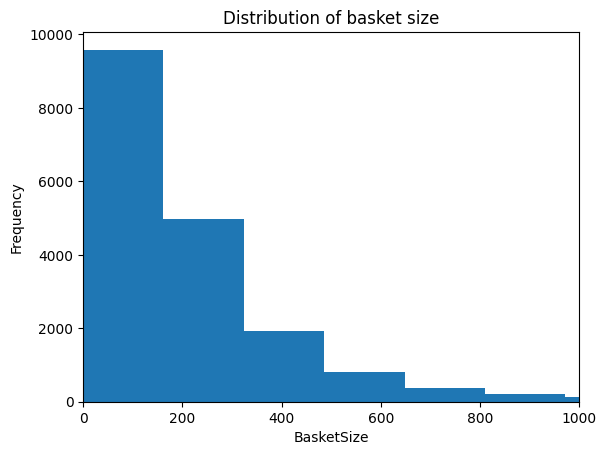

In [63]:
values_distribution(basket_size,'BasketSize',bins=1000,xlim=1000,title='Distribution of basket size',xlabel='BasketSize')

In [64]:
def averaging(df,group_col,summary_col,new_col):
  rdd = df.rdd

  rdd_keyed = rdd.map(lambda row: (row[group_col], row[summary_col]))

  rdd_reduced = rdd_keyed.aggregateByKey((0.0, 0), lambda acc, val: (acc[0] + val, acc[1] + 1), lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1]))

  rdd_output = rdd_reduced.map(lambda row: (row[0], row[1][0] / row[1][1]))

  output = rdd_output.toDF([group_col, new_col])
  return output

In [65]:
avg_basket_price = averaging(basket_price,'CustomerID','TotalCost','AvgBasketPrice')
show_df(avg_basket_price)

+----------+------------------+
|CustomerID|    AvgBasketPrice|
+----------+------------------+
|   12346.0|               0.0|
|   12347.0| 615.7142857142857|
|   12348.0|            449.31|
|   12349.0|1757.5500000000006|
|   12350.0|             334.4|
+----------+------------------+
only showing top 5 rows



In [66]:
avg_basket_size = averaging(basket_size,'CustomerID','BasketSize','AvgBasketSize')
show_df(avg_basket_size)

+----------+------------------+
|CustomerID|     AvgBasketSize|
+----------+------------------+
|   12356.0| 530.3333333333334|
|   12408.0|155.44444444444446|
|   12424.0|             370.0|
|   12484.0|           272.625|
|   12488.0|176.33333333333334|
+----------+------------------+
only showing top 5 rows



In [67]:
# print shapes of the DataFrames
print("avg_basket_price: ", (avg_basket_price.count(), len(avg_basket_price.columns)))
print("frequency_of_purchases: ", (frequency_of_purchases.count(), len(frequency_of_purchases.columns)))
print("basket_size: ", (avg_basket_size.count(), len(avg_basket_size.columns)))
print("customer_lifetime_value: ", (customer_lifetime_value.count(), len(customer_lifetime_value.columns)))

avg_basket_price:  (4330, 2)
frequency_of_purchases:  (4330, 2)
basket_size:  (4330, 2)
customer_lifetime_value:  (4330, 2)


In [68]:
dfs = [avg_basket_price, frequency_of_purchases, avg_basket_size, customer_lifetime_value]

df_final = reduce(lambda left, right: left.join(right, on='CustomerID', how='outer'), dfs)

show_df(df_final)

+----------+------------------+--------------------+------------------+---------------------+
|CustomerID|    AvgBasketPrice|FrequencyOfPurchases|     AvgBasketSize|CustomerLifetimeValue|
+----------+------------------+--------------------+------------------+---------------------+
|   12346.0|               0.0|                   2|               0.0|                    0|
|   12347.0| 615.7142857142857|                   7|351.14285714285717|                  365|
|   12348.0|            449.31|                   4|            585.25|                  283|
|   12349.0|1757.5500000000006|                   1|             631.0|                    0|
|   12350.0|             334.4|                   1|             197.0|                    0|
+----------+------------------+--------------------+------------------+---------------------+
only showing top 5 rows



In [69]:
df_stats(df_final)

+-------+------------------+------------------+--------------------+------------------+---------------------+
|summary|        CustomerID|    AvgBasketPrice|FrequencyOfPurchases|     AvgBasketSize|CustomerLifetimeValue|
+-------+------------------+------------------+--------------------+------------------+---------------------+
|  count|              4330|              4330|                4330|              4330|                 4330|
|   mean|15298.841570438799| 320.1514824114407|   5.109699769053118|198.04146442253705|   134.67759815242493|
| stddev|1722.4909404131333|350.99029037640355|   9.376827828095207|321.38101330429146|   133.05474180466499|
|    min|           12346.0|               0.0|                   1|             -94.5|                    0|
|    max|           18287.0|           6207.67|                 248|           12540.0|                  373|
+-------+------------------+------------------+--------------------+------------------+---------------------+



## product returns

In [70]:
def map_func(row):
    customer_id = row['CustomerID']
    invoice_no = row['InvoiceNo']
    is_return = 1 if invoice_no.startswith('C') else 0
    return (customer_id, (is_return, 1))

def reduce_func(x, y):
    return (x[0] + y[0], x[1] + y[1])

customer_returns = df_spark_filtered.select('CustomerID', 'InvoiceNo').distinct().rdd.map(map_func).reduceByKey(reduce_func)
product_returns = customer_returns.map(lambda x: (x[0], x[1][0] / x[1][1] if x[1][1] > 0 else 0))
product_returns = spark.createDataFrame(product_returns.collect(), ['CustomerID', 'ProductReturns'])
product_returns.sample(False, 0.001).show()

+----------+--------------+
|CustomerID|ProductReturns|
+----------+--------------+
+----------+--------------+



In [71]:
df_spark_filtered.filter(df_spark_filtered['CustomerID'] == 14792.0).select('InvoiceNo').distinct().show()


+---------+
|InvoiceNo|
+---------+
|   570003|
|  C569954|
+---------+



## basket diversity

In [72]:
basket_diversity = (df_spark_filtered
                   .groupBy("CustomerID", "InvoiceNo")
                   .agg(countDistinct("StockCode").alias("unique_stock_count"))
                   .groupBy("CustomerID")
                   .agg(mean("unique_stock_count").alias("basket_diversity"))
                   .select("CustomerID", "basket_diversity"))
basket_diversity.sample(False, 0.001).show()

+----------+-----------------+
|CustomerID| basket_diversity|
+----------+-----------------+
|   17660.0|             37.0|
|   16923.0|24.23076923076923|
|   17631.0|             13.0|
+----------+-----------------+



In [73]:
cust=df_spark_filtered.filter(df_spark_filtered['CustomerID'] == 17314.0).distinct().select('CustomerID', 'InvoiceNo', 'StockCode')
cust=cust.groupBy('CustomerID', 'InvoiceNo').agg(countDistinct('StockCode').alias('unique_stock_count'))
cust.show()
cust=cust.groupBy('CustomerID').agg(mean('unique_stock_count').alias('basket_diversity'))
cust.show()

+----------+---------+------------------+
|CustomerID|InvoiceNo|unique_stock_count|
+----------+---------+------------------+
|   17314.0|   542641|                 5|
|   17314.0|  C544829|                 2|
|   17314.0|   547885|                 7|
|   17314.0|   557898|                24|
|   17314.0|   575911|                17|
|   17314.0|   576385|                 1|
|   17314.0|   559980|                 8|
|   17314.0|   542786|                21|
|   17314.0|  C548307|                 1|
|   17314.0|  C572482|                 2|
|   17314.0|   570855|                48|
+----------+---------+------------------+

+----------+------------------+
|CustomerID|  basket_diversity|
+----------+------------------+
|   17314.0|12.363636363636363|
+----------+------------------+



## unique transactions per quarter

In [74]:
quarter1 = df_spark_filtered.filter(quarter(df_spark_filtered['InvoiceDate']) == 1)
quarter1 = quarter1.groupBy('CustomerID').agg(countDistinct('InvoiceNo').alias('unique_transactions_q1'))
quarter2=df_spark_filtered.filter(quarter(df_spark_filtered['InvoiceDate']) == 2)
quarter2 = quarter2.groupBy('CustomerID').agg(countDistinct('InvoiceNo').alias('unique_transactions_q2'))
quarter3=df_spark_filtered.filter(quarter(df_spark_filtered['InvoiceDate']) == 3)
quarter3 = quarter3.groupBy('CustomerID').agg(countDistinct('InvoiceNo').alias('unique_transactions_q3'))
quarter4=df_spark_filtered.filter(quarter(df_spark_filtered['InvoiceDate']) == 4)
quarter4 = quarter4.groupBy('CustomerID').agg(countDistinct('InvoiceNo').alias('unique_transactions_q4'))

quarters = quarter1.join(quarter2, 'CustomerID', 'outer')
quarters = quarters.join(quarter3, 'CustomerID', 'outer')
quarters = quarters.join(quarter4, 'CustomerID', 'outer')
quarters = quarters.na.fill(0)

In [75]:
copy_filtered = df_spark_filtered.select('*')
print(copy_filtered.count())
copy_filtered=copy_filtered.join(quarters, 'CustomerID', 'outer')
copy_filtered=copy_filtered.join(basket_diversity, 'CustomerID', 'outer')
copy_filtered=copy_filtered.join(product_returns, 'CustomerID', 'outer')


401376


In [76]:
features = copy_filtered.dropDuplicates(['CustomerID'])
print("len:  ",features.count())

len:   4330


In [77]:
features = features.select(['CustomerID','unique_transactions_q1','unique_transactions_q2','unique_transactions_q3','unique_transactions_q4','basket_diversity','ProductReturns'])
df_final =df_final.join(features,'CustomerID','left') 

## Concatenate features in one vector

In [78]:
assembler = VectorAssembler(inputCols=['AvgBasketPrice', 'FrequencyOfPurchases', 'AvgBasketSize', 'CustomerLifetimeValue','unique_transactions_q1','unique_transactions_q2','unique_transactions_q3','unique_transactions_q4','basket_diversity','ProductReturns'
                                       ], outputCol='features')

df_final = assembler.transform(df_final)


scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=False)

scalerModel = scaler.fit(df_final)

df_assembled = scalerModel.transform(df_final)

show_df(df_assembled)


+----------+------------------+--------------------+-----------------+---------------------+----------------------+----------------------+----------------------+----------------------+------------------+------------------+--------------------+--------------------+
|CustomerID|    AvgBasketPrice|FrequencyOfPurchases|    AvgBasketSize|CustomerLifetimeValue|unique_transactions_q1|unique_transactions_q2|unique_transactions_q3|unique_transactions_q4|  basket_diversity|    ProductReturns|            features|      scaledFeatures|
+----------+------------------+--------------------+-----------------+---------------------+----------------------+----------------------+----------------------+----------------------+------------------+------------------+--------------------+--------------------+
|   12493.0|            138.93|                   3|68.66666666666667|                   32|                     0|                     3|                     0|                     0| 7.666666666666667|0.

# K-means Clustering

## choose value of K

wcss:  109424076.14266597
wcss:  92614566.71819682
wcss:  81913625.86759302
wcss:  77766897.36807083
wcss:  68990616.51577921
wcss:  70949669.69799948
wcss:  62339281.12031104
wcss:  59774673.623276316


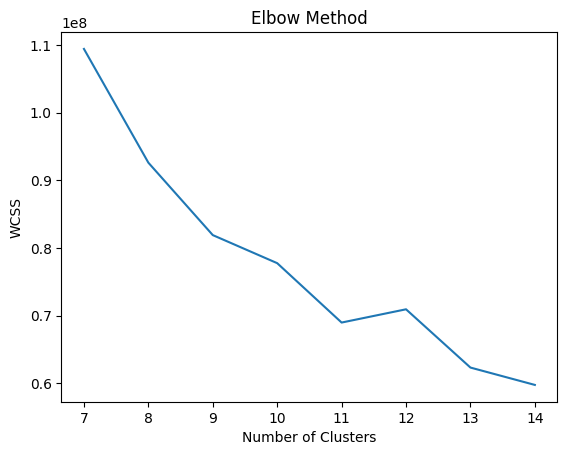

In [85]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

train_data, test_data = df_assembled.randomSplit([0.7, 0.3], seed=42)
train_data = train_data.repartition(8)
test_data = test_data.repartition(8)

wcss = []
for i in range(7, 15):
    kmeans = KMeans(featuresCol='features',maxIter=30, k=i)
    model = kmeans.fit(train_data)
    cost = model.summary.trainingCost
    wcss.append(cost)
    print('wcss: ', cost)

plt.plot(range(7, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

wcss:  52760206.73959843
wcss:  50615092.579613775
wcss:  46759257.54604446
wcss:  44582581.61712058
wcss:  43028996.79324972


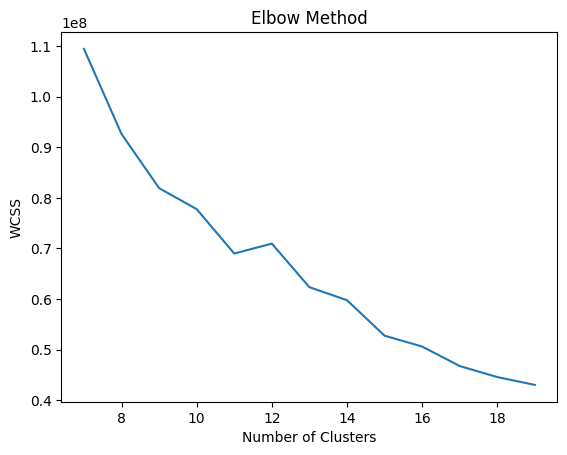

In [86]:
for i in range(15, 20):
    kmeans = KMeans(featuresCol='features',maxIter=30, k=i)
    model = kmeans.fit(train_data)
    cost = model.summary.trainingCost
    wcss.append(cost)
    print('wcss: ', cost)

plt.plot(range(7, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

### Train KMean

In [90]:
WCSscaled_features_pd = df_assembled.select('features')

train_data, test_data = df_assembled.randomSplit([0.7, 0.3], seed=42)
train_data = train_data.repartition(8)
test_data = test_data.repartition(8)

kmeans = KMeans(featuresCol='features', k=11)

model = kmeans.fit(train_data)

predictions = model.transform(test_data)

# print the cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[1.33244158e+02 2.14681107e+00 7.34980332e+01 3.02551143e+01
 3.28519856e-01 4.53670277e-01 4.94584838e-01 8.70036101e-01
 1.23335115e+01 1.14682236e-01]
[2.5492e+03 1.0000e+00 4.2900e+03 0.0000e+00 0.0000e+00 5.0000e-01
 0.0000e+00 5.0000e-01 1.5000e+00 0.0000e+00]
[6.08834874e+02 3.66666667e+00 1.26030593e+03 1.06277778e+02
 7.77777778e-01 1.00000000e+00 1.00000000e+00 8.88888889e-01
 1.73953824e+01 3.01587302e-02]
[3.02021821e+02 2.08960573e+00 1.84106989e+02 3.32813620e+01
 2.18637993e-01 3.70967742e-01 6.07526882e-01 8.92473118e-01
 2.08906241e+01 6.21359201e-02]
[4.62658924e+03 1.02857143e+01 1.99774654e+03 9.31428571e+01
 1.00000000e+00 2.14285714e+00 3.42857143e+00 3.71428571e+00
 7.86762673e+01 4.03225806e-02]
[3.78161570e+02 1.00324074e+01 2.36230658e+02 2.81277778e+02
 1.86342593e+00 2.34490741e+00 2.43981481e+00 3.38425926e+00
 2.17581144e+01 1.17223719e-01]
[2.20597853e+03 1.37333333e+01 1.24732139e+03 2.24333333e+02
 2.53333333e+00 2.46666667e+00 3.66666

### KMean Train Score

In [91]:
train_clusters = model.transform(train_data)
# evaluate the model on the training data
from pyspark.ml.evaluation import ClusteringEvaluator

# calculate the evaluation metrics
evaluator = ClusteringEvaluator()
#s(i) = (b(i) - a(i)) / max(a(i), b(i))
#a(i) is the average distance between i and all other points in its cluster
#b(i) is the smallest average distance between i and all points in any other cluster.
#A score of 1 means that the data point fits well into its assigned cluster and poorly into other clusters.
#A score of 0 means that the data point is on the boundary between two clusters.
#A score of -1 means that the data point fits poorly into its assigned cluster and well into other clusters.
silhouette = evaluator.evaluate(train_clusters)

# print the evaluation metrics
print("Silhouette Score for Training Data = " + str(silhouette))

Silhouette Score for Training Data = 0.5279819014447092


### KMean Test Score

In [92]:
# evaluate the model using the evaluation metrics
from pyspark.ml.evaluation import ClusteringEvaluator

# Calculate the evaluation metrics
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)

# Print the evaluation metrics
print("Silhouette with squared euclidean distance = " + str(silhouette))



Silhouette with squared euclidean distance = 0.5163033388495715


### Adding the clusters labels to data

In [93]:

# concatenate the training and testing data
all_data_with_clusters = train_clusters.union(predictions)
print(all_data_with_clusters.count())
all_data_with_clusters.show(5)

4330
+----------+------------------+--------------------+------------------+---------------------+----------------------+----------------------+----------------------+----------------------+------------------+-------------------+--------------------+--------------------+----------+
|CustomerID|    AvgBasketPrice|FrequencyOfPurchases|     AvgBasketSize|CustomerLifetimeValue|unique_transactions_q1|unique_transactions_q2|unique_transactions_q3|unique_transactions_q4|  basket_diversity|     ProductReturns|            features|      scaledFeatures|prediction|
+----------+------------------+--------------------+------------------+---------------------+----------------------+----------------------+----------------------+----------------------+------------------+-------------------+--------------------+--------------------+----------+
|   13107.0|           304.814|                   5|             257.6|                  289|                     2|                     1|                     1

### Clusters Distribution

In [94]:
# Distribution of the clusters
all_data_with_clusters.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         6|   19|
|         3|  795|
|         5|  599|
|         9|   59|
|         8|  378|
|         7|  214|
|        10| 1043|
|         2|   24|
|         0| 1183|
|         4|   11|
|         1|    5|
+----------+-----+



### Visualize Clusters

In [96]:
predictions_pd = all_data_with_clusters.select('scaledFeatures').toPandas()

# number of variables
categories = ['AvgBasketPrice', 'FrequencyOfPurchases', 'AvgBasketSize', 'CustomerLifetimeValue','unique_transactions_q1','unique_transactions_q2','unique_transactions_q3','unique_transactions_q4','basket_diversity','ProductReturns']
# create a list to store the radar charts
charts = []

radar_style = pygal.style.Style(background='radial-gradient(#fff, #bbb)')

# Create a radar chart for each cluster
for i in range(len(centers)):
    values = predictions_pd.loc[i, 'scaledFeatures'].toArray().flatten().tolist()
    chart = pygal.Radar(fill=True, style=radar_style)
    chart.title = 'Cluster %d' % (i + 1)
    chart.x_labels = categories
    chart.add('Cluster %d' % (i + 1), [x for x in values], fill_color='red')
    chart.show_legend = True
    chart.render_to_file('cluster%d.svg' % (i + 1))
    charts.append(chart)

# create a combined radar chart from the list of charts
combined_chart = pygal.StackedLine(fill=True, interpolate='cubic', style=pygal.style.LightStyle)
combined_chart.title = 'Cluster Analysis'
combined_chart.x_labels = categories
for i in range(len(centers)):
    values = predictions_pd.loc[i, 'scaledFeatures'].toArray().flatten().tolist() 
    combined_chart.add('Cluster %d' % (i + 1), [x for x in values])
combined_chart.render_to_file('cluster_analysis.svg')
    

# BisectingKMeans

In [100]:
# Split the data into training and testing sets
train_data_heirc, test_data_heirc = df_assembled.randomSplit([0.7, 0.3], seed=42)
train_data_heirc = train_data_heirc.repartition(8)
test_data_heirc = test_data_heirc.repartition(8)

# create an instance of the K-means algorithm
bisecting_kmeans = BisectingKMeans(featuresCol='features', k=11)

# train the model on the training data
model = bisecting_kmeans.fit(train_data_heirc)

# make predictions on the testing data
predictions_heirc = model.transform(test_data_heirc)

# print the cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[1.23496434e+02 2.19157609e+00 6.69272712e+01 3.23247283e+01
 3.36956522e-01 4.75543478e-01 5.08152174e-01 8.70923913e-01
 1.13437474e+01 1.19192850e-01]
[2.69507869e+02 2.02830189e+00 1.58796633e+02 2.78849057e+01
 2.20754717e-01 3.60377358e-01 5.37735849e-01 9.09433962e-01
 1.96094137e+01 7.20683928e-02]
[1.50652441e+02 8.57800000e+00 7.99570299e+01 2.75320000e+02
 1.75000000e+00 1.92600000e+00 1.82600000e+00 3.07600000e+00
 1.34056145e+01 1.58910157e-01]
[2.73623187e+02 8.87581699e+00 1.66652890e+02 2.77483660e+02
 1.61437908e+00 2.13943355e+00 2.09150327e+00 3.03050109e+00
 1.89378322e+01 1.47533315e-01]
[4.37236408e+02 2.09868421e+00 2.71690520e+02 3.67664474e+01
 2.40131579e-01 3.58552632e-01 6.11842105e-01 8.88157895e-01
 2.65873893e+01 5.24390449e-02]
[4.31347233e+02 1.02284644e+01 2.70106367e+02 2.70494382e+02
 1.99250936e+00 2.38951311e+00 2.52808989e+00 3.31835206e+00
 2.36842471e+01 9.96485721e-02]
[7.14909144e+02 4.93500000e+00 4.49588546e+02 1.26450000e+

### BisectingKMeans Train Score

In [101]:
train_clusters_heirc = model.transform(train_data_heirc)
# evaluate the model on the training data
from pyspark.ml.evaluation import ClusteringEvaluator

# calculate the evaluation metrics
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(train_clusters_heirc)

# calculate the silhouette score
#s(i) = (b(i) - a(i)) / max(a(i), b(i))
#a(i) is the average distance between i and all other points in its cluster
#b(i) is the smallest average distance between i and all points in any other cluster.
#A score of 1 means that the data point fits well into its assigned cluster and poorly into other clusters.
#A score of 0 means that the data point is on the boundary between two clusters.
#A score of -1 means that the data point fits poorly into its assigned cluster and well into other clusters.

# print the evaluation metrics
print("Silhouette Score for Training Data = " + str(silhouette))

Silhouette Score for Training Data = 0.4397139750535838


### BisectingKMeans Test Score

In [102]:
# evaluate the model using the evaluation metrics
from pyspark.ml.evaluation import ClusteringEvaluator

# Calculate the evaluation metrics
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions_heirc)

# Print the evaluation metrics
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.43566822896166735


In [103]:
# concatenate the training and testing data
all_data_with_clusters_heirc = train_clusters_heirc.union(predictions_heirc)

### BisectingKMeans Clusters Distribution

In [104]:
# Distribution of the clusters
all_data_with_clusters_heirc.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  753|
|         6|  284|
|         3|  638|
|         5|  369|
|         9|   14|
|         4|  421|
|         8|   42|
|         7|   80|
|         2|  675|
|         0| 1049|
|        10|    5|
+----------+-----+



### Visualize BisectingKMeans Clusters

In [113]:
# predictions_pd = all_data_with_clusters_heirc.select('scaledFeatures').toPandas()

# number of variables
categories = ['AvgBasketPrice', 'FrequencyOfPurchases', 'AvgBasketSize', 'CustomerLifetimeValue','unique_transactions_q1','unique_transactions_q2','unique_transactions_q3','unique_transactions_q4','basket_diversity','ProductReturns']
# create a list to store the radar charts
charts = []

radar_style = pygal.style.Style(background='radial-gradient(#fff, #bbb)')

# Create a radar chart for each cluster
for i in range(len(centers)):
    values = predictions_pd.loc[i, 'scaledFeatures'].toArray().flatten().tolist()
    chart = pygal.Radar(fill=True, style=radar_style)
    chart.title = 'Cluster %d' % (i + 1)
    chart.x_labels = categories
    chart.add('Cluster %d' % (i + 1), [x for x in values], fill_color='red')
    chart.show_legend = True
    chart.render_to_file('hei_cluster%d.svg' % (i + 1))
    charts.append(chart)

# create a combined radar chart from the list of charts
combined_chart = pygal.StackedLine(fill=True, interpolate='cubic', style=pygal.style.LightStyle)
combined_chart.title = 'Cluster Analysis'
combined_chart.x_labels = categories
for i in range(len(centers)):
    values = predictions_pd.loc[i, 'scaledFeatures'].toArray().flatten().tolist() 
    combined_chart.add('Cluster %d' % (i + 1), [x for x in values])
combined_chart.render_to_file('hei_cluster_analysis.svg')
    

In [107]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs

train_data_aggclust, test_data_aggclust = df_assembled.randomSplit([0.7, 0.3], seed=42)
train_data_aggclust = train_data_aggclust.repartition(8)
test_data_aggclust = test_data_aggclust.repartition(8)

# convert PySpark DataFrame to Pandas DataFrame
X_train = train_data_aggclust.toPandas()
X_test = test_data_aggclust.toPandas()

In [ ]:
X_train.columns

In [108]:
# create an instance of the AgglomerativeClustering algorithm
aggclust = AgglomerativeClustering(n_clusters=11, linkage="complete")
X = X_train['features'].to_list()
# fit the model to the data
model = aggclust.fit(X)
train_assignments = model.labels_
print(len(train_assignments))

3097


In [109]:
# get the cluster assignments for the test data
predictions = model.fit_predict(X_test['features'].to_list())

In [110]:
from sklearn.metrics import silhouette_score
# compute the silhouette score
score = silhouette_score(X_test['features'].to_list(), predictions)

print(f"Silhouette Score: {score}")

Silhouette Score: 0.48586184749305805


In [111]:
x_clusters_aggclust = X_train.assign(prediction=train_assignments)

In [112]:
x_clusters_aggclust.groupby('prediction').count()

,CustomerID,AvgBasketPrice,FrequencyOfPurchases,AvgBasketSize,CustomerLifetimeValue,unique_transactions_q1,unique_transactions_q2,unique_transactions_q3,unique_transactions_q4,basket_diversity,ProductReturns,features,scaledFeatures
prediction,,,,,,,,,,,,,
0,2936,2936,2936,2936,2936,2936,2936,2936,2936,2936,2936,2936,2936
1,5,5,5,5,5,5,5,5,5,5,5,5,5
2,9,9,9,9,9,9,9,9,9,9,9,9,9
3,106,106,106,106,106,106,106,106,106,106,106,106,106
4,15,15,15,15,15,15,15,15,15,15,15,15,15
5,2,2,2,2,2,2,2,2,2,2,2,2,2
6,15,15,15,15,15,15,15,15,15,15,15,15,15
7,2,2,2,2,2,2,2,2,2,2,2,2,2
8,1,1,1,1,1,1,1,1,1,1,1,1,1


In [114]:
from google.colab import files
!zip -r /content/Images.zip /content/Images

  adding: content/Images/ (stored 0%)
  adding: content/Images/hei_cluster1.svg (deflated 78%)
  adding: content/Images/cluster2.svg (deflated 79%)
  adding: content/Images/cluster10.svg (deflated 78%)
  adding: content/Images/hei_cluster10.svg (deflated 78%)
  adding: content/Images/cluster4.svg (deflated 79%)
  adding: content/Images/hei_cluster_analysis.svg (deflated 61%)
  adding: content/Images/cluster8.svg (deflated 79%)
  adding: content/Images/cluster7.svg (deflated 79%)
  adding: content/Images/cluster5.svg (deflated 78%)
  adding: content/Images/hei_cluster5.svg (deflated 78%)
  adding: content/Images/cluster1.svg (deflated 78%)
  adding: content/Images/cluster_analysis.svg (deflated 61%)
  adding: content/Images/hei_cluster6.svg (deflated 78%)
  adding: content/Images/sample_data/ (stored 0%)
  adding: content/Images/sample_data/README.md (deflated 42%)
  adding: content/Images/sample_data/california_housing_train.csv (deflated 79%)
  adding: content/Images/sample_data/mnist

In [115]:
files.download('/content/Images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>